In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from random_words import RandomWords
from tqdm import tqdm_notebook as tqdm

rw = RandomWords()

In [4]:
#Get file paths for HWR words
HWR_words_globs = ['/home/rob/HWR/datasets/cvl-database-1-1/trainset/words/*/*.tif',
                  '/home/rob/HWR/datasets/RIMES/trainingsnippets_icdar/training_WR/**/*.tiff',
                  "/home/rob/HWR/datasets/IAM/words/**/*.png",
                  "/home/rob/HWR/datasets/IAMHist/washingtondb-v1.0/washingtondb-v1.0/**/*.png"]

HWR_words_fps = []
for glob_path in HWR_words_globs:
    HWR_words_fps += glob(glob_path)
np.random.choice(HWR_words_fps)

'/home/rob/HWR/datasets/cvl-database-1-1/trainset/words/0006/0006-8-4-3-was.tif'

In [5]:
def make_fake_mixed_label(blank_fp):
    if not os.path.exists(blank_fp):
        return None

    #start position should be somewhat random
    sx_min = 10
    sx_max = 30
    sy_min = 20
    sy_max = 250
    space_y_min = 30
    space_y_max = 150
    space_x_min = 1
    space_x_max = 150
    word_height_min = 100
    word_height_max = 200
    space_left_on_label = True
    word_scale_min = 7
    word_scale_max = 13
    word_thickness_min = 10
    word_thickness_max = 25    
    word_height_min = 100
    word_height_max = 200

    sx = np.random.randint(sx_min, sx_max)
    sy = np.random.randint(sy_min, sy_max)

    space_y = np.random.randint(space_y_min, space_y_max)

    restart = True
    _try = 0
    _max_tries = 5
    while (restart == True) & (_try < _max_tries):
        blank = cv2.imread(blank_fp)
        gray = cv2.cvtColor(blank, cv2.COLOR_BGR2GRAY)
        faked = blank.copy()

        word_types = ['HWR','OCR']
        word_type = np.random.choice(word_types)
        word_types_used = [word_type]

        if word_type == 'OCR':
            word_scale = np.random.randint(word_scale_min,word_scale_max)
            word_thickness = np.random.randint(word_thickness_min,word_thickness_max)
            word_font = np.random.randint(0,6)
            color = (np.random.randint(0,140),np.random.randint(0,50),np.random.randint(0,50))

            word = rw.random_word()
            (label_width, label_height), baseline = cv2.getTextSize(word, word_font, word_scale, word_thickness)
            ex = sx + label_height
            ey = sy + label_width
            
            a_try = 0
            while ((ey >= faked.shape[1]) | (ex >= faked.shape[0])) & (a_try < 4):
                word = rw.random_word()
                (label_width, label_height), baseline = cv2.getTextSize(word, word_font, word_scale, word_thickness)
                ex = sx + label_height
                ey = sy + label_width
                a_try += 1
            if a_try >= 4:
                return None

            faked = cv2.putText(faked,word,(sy,ex),word_font,word_scale,color,word_thickness)

        if word_type == 'HWR':
            word_fp = np.random.choice(HWR_words_fps)
            word = cv2.imread(word_fp)
            word_height = np.random.randint(word_height_min,word_height_max)
            word_scale = word_height/word.shape[0]
            word = cv2.resize(word, (int(word.shape[1]*word_scale),int(word.shape[0]*word_scale)))
            label_height = word.shape[0]
            label_width = word.shape[1]
            ex = sx + label_height
            ey = sy + label_width

            
            a_try = 0
            while ((ey >= faked.shape[1]) | (ex >= faked.shape[0])) & (a_try < 4):
                word_fp = np.random.choice(HWR_words_fps)
                word = cv2.imread(word_fp)
                word_height = np.random.randint(word_height_min,word_height_max)
                word_scale = word_height/word.shape[0]
                word = cv2.resize(word, (int(word.shape[1]*word_scale),int(word.shape[0]*word_scale)))
                label_height = word.shape[0]
                label_width = word.shape[1]
                ex = sx + label_height
                ey = sy + label_width
                a_try += 1
            if a_try >= 4:
                return None
            #time.sleep(1)

            for j in range(label_width):
                y = sy + j
                for i in range(label_height):
                    x = sx + i
                    value = gray[x,y]*((255-word[i,j])/255)
                    channels = faked[x,y] - value
                    channels[0] = max(channels[0],0)
                    channels[1] = max(channels[1],0)
                    channels[2] = max(channels[2],0)
                    faked[x,y] = channels


        space_left_on_label = True
        while space_left_on_label:
            word_type = np.random.choice(word_types)

            space_y = np.random.randint(space_y_min, space_y_max)
            sx = ex - label_height
            sy = ey + space_y


            if word_type == 'OCR':
                word_scale = np.random.randint(word_scale_min,word_scale_max)
                word_thickness = np.random.randint(word_thickness_min,word_thickness_max)
                word_font = np.random.randint(0,6)
                color = (np.random.randint(0,140),np.random.randint(0,50),np.random.randint(0,50))

                word = rw.random_word()
                (label_width, label_height), baseline = cv2.getTextSize(word, word_font, word_scale, word_thickness)
                ex = sx + label_height
                ey = sy + label_width

                if ey > faked.shape[1]:
                    #move to new line
                    space_x = np.random.randint(space_x_min, space_x_max)
                    sx = ex + space_x
                    sy = np.random.randint(sy_min, sy_max)
                    ex = sx + label_height
                    ey = sy + label_width

                    if ey > faked.shape[1]:
                        break

                if ex > faked.shape[0]:
                    break

                faked = cv2.putText(faked,word,(sy,ex),word_font,word_scale,color,word_thickness)

            if word_type == 'HWR':
                word_fp = np.random.choice(HWR_words_fps)
                word = cv2.imread(word_fp)
                word_height = np.random.randint(word_height_min,word_height_max)
                word_scale = word_height/word.shape[0]
                word = cv2.resize(word, (int(word.shape[1]*word_scale),int(word.shape[0]*word_scale)))
                ex = sx + word.shape[0]
                ey = sy + word.shape[1]
                label_height = word.shape[0]
                label_width = word.shape[1]

                #check if word is too wide to fit on label
                if ey > faked.shape[1]:
                    #move to new line
                    space_x = np.random.randint(space_x_min, space_x_max)
                    sx = ex + space_x
                    sy = np.random.randint(sy_min, sy_max)
                    ex = sx + label_height
                    ey = sy + label_width

                    if ey > faked.shape[1]:
                        space_left_on_label = False
                        break

                if ex > faked.shape[0]:
                    space_left_on_label = False
                    break

                for j in range(word.shape[1]):
                    y = sy + j
                    for i in range(word.shape[0]):
                        x = sx + i
                        value = gray[x,y]*((255-word[i,j])/255)
                        channels = faked[x,y] - value
                        channels[0] = max(channels[0],0)
                        channels[1] = max(channels[1],0)
                        channels[2] = max(channels[2],0)
                        faked[x,y] = channels



            word_types_used += [word_type]
        
        if ('HWR' in word_types_used) & ('OCR' in word_types_used):
            restart = False
        else:
            restart = True
            _try += 1
            continue
        
        k = 0
        for j in range(faked.shape[1]):
            for i in range(faked.shape[0]):
                replace_every = np.random.randint(12)
                if (faked[i,j] == color).all():
                    k += 1
                    if k >= replace_every:
                        k = 0
                        noise = np.random.randint(-20,20)
                        #faked[i,j,0] =  min(max(faked[i,j,0] + noise,0),255)
                        #faked[i,j,1] =  min(max(faked[i,j,1] + noise,0),255)
                        #faked[i,j,2] =  min(max(faked[i,j,2] + noise,0),255)
                        faked[i,j] = faked[np.random.randint(faked.shape[0]),np.random.randint(faked.shape[1])] + noise





    faked_fp = blank_fp.replace('Blank','Faked_Mix')
    cv2.imwrite(faked_fp,faked)

In [6]:
types = ['Handwritten','Machine-written','Mixed']

df = pd.read_csv('box coords.csv', index_col=0)
df = df.sample(frac=1)
df.head()
failed = 0
for name,row in tqdm(df.iterrows(), total=len(df)):
    orig_fp = row['orig_fp']
    orig = cv2.imread(orig_fp)
    
    blank_fp = row['orig_fp'].replace('Label','Blank')
    
    fake_label_type = np.random.choice(types)
    make_fake_mixed_label(blank_fp)


In [59]:
word_types_used


['OCR', 'HWR']

1
HWR
2
1
HWR


True

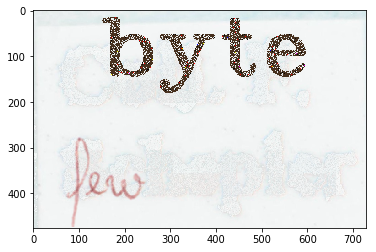

In [52]:

plt.imshow(faked)

In [48]:
word_fp

'/home/rob/HWR/datasets/IAMHist/washingtondb-v1.0/washingtondb-v1.0/ground_truth/transcription.txt'

In [235]:
ey

478

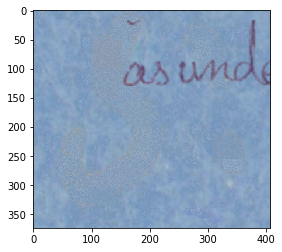

In [233]:
plt.imshow(faked)